In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Animal dataset

path='/content/drive/MyDrive/PRNN/Assign_3/animal/animals10_data.npz'
data = np.load(path)

# Load the data from the .npz file
image_data = np.load(path)
image_data=image_data['data']
# Extract images and labels
labels = data['labels']

In [4]:
# Define the sizes for training, validation, and testing sets
train_size = int(0.7 * len(image_data))
val_size = int(0.2 * len(image_data))
test_size = len(image_data) - train_size - val_size

# Shuffle the data
indices = np.random.permutation(len(image_data))
image_data_shuffled = image_data[indices]
labels_shuffled = labels[indices]

# Split the data into training, validation, and testing sets
x_train = image_data_shuffled[:train_size]
y_train = labels_shuffled[:train_size]

x_val = image_data_shuffled[train_size:train_size+val_size]
y_val = labels_shuffled[train_size:train_size+val_size]

x_test = image_data_shuffled[train_size+val_size:]
y_test = labels_shuffled[train_size+val_size:]

# Print the shapes of the split sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of x_train: (18325, 4096)
Shape of y_train: (18325,)
Shape of x_val: (5235, 4096)
Shape of y_val: (5235,)
Shape of x_test: (2619, 4096)
Shape of y_test: (2619,)


In [5]:
#News Category data set
import pandas as pd

news_path='/content/drive/MyDrive/PRNN/Assign_3/News/News_Category_Dataset_v3.json'

text_df = pd.read_json(news_path, lines=True)

columns = ['headline', 'category']
text_df = text_df[columns]
print(text_df.head())

# Count the occurrences of each category
category_counts = text_df['category'].value_counts()

# Select the top 12 categories by occurrences
top_categories = category_counts.head(12).index.tolist()

# Filter the dataframe to keep only the rows with top categories
filtered_df = text_df[text_df['category'].isin(top_categories)]

# One-hot encode the categories
one_hot_encoded = pd.get_dummies(filtered_df['category'])
labels = np.argmax(one_hot_encoded.to_numpy().astype('int'),axis = 1)

x_text = filtered_df['headline'].copy()
y_text = labels.copy()



                                            headline   category
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY
3  The Funniest Tweets From Parents This Week (Se...  PARENTING
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS


In [6]:
print(x_text)
print(y_text)

2         23 Of The Funniest Tweets About Cats And Dogs ...
3         The Funniest Tweets From Parents This Week (Se...
17        Maury Wills, Base-Stealing Shortstop For Dodge...
20        Golden Globes Returning To NBC In January Afte...
21        Biden Says U.S. Forces Would Defend Taiwan If ...
                                ...                        
209513    'Girl With the Dragon Tattoo' India Release Ca...
209523    Maria Sharapova Stunned By Victoria Azarenka I...
209524    Giants Over Patriots, Jets Over Colts Among  M...
209525    Aldon Smith Arrested: 49ers Linebacker Busted ...
209526    Dwight Howard Rips Teammates After Magic Loss ...
Name: headline, Length: 135264, dtype: object
[1 5 8 ... 8 8 8]


In [7]:
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300, distance_metric='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.distance_metric = distance_metric
        self.centroids = None

    def fit(self, X):
        # Initialize centroids randomly
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_clusters(X)

            # Update centroids based on the mean of data points in each cluster
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def _assign_clusters(self, X):
        # Compute distances between each data point and each centroid
        if self.distance_metric == 'euclidean':
            distances = np.sqrt(np.sum((X[:, np.newaxis] - self.centroids) ** 2, axis=2))
        elif self.distance_metric == 'manhattan':
            distances = np.sum(np.abs(X[:, np.newaxis] - self.centroids), axis=2)
        elif self.distance_metric == 'cosine':
            norms_X = np.linalg.norm(X, axis=1)
            norms_centroids = np.linalg.norm(self.centroids, axis=1)
            dot_products = np.dot(X, self.centroids.T)
            distances = 1 - dot_products / np.outer(norms_X, norms_centroids)

        # Assign each data point to the nearest centroid
        return np.argmin(distances, axis=1)

    def _calculate_distance(self, X, centroids):
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((X - centroids[:, np.newaxis])**2, axis=2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(X - centroids[:, np.newaxis]), axis=2)
        elif self.distance_metric == 'cosine':
            norms = np.linalg.norm(X, axis=1)
            centroid_norms = np.linalg.norm(centroids, axis=1)
            cosine_similarity = np.dot(X, centroids.T) / (norms[:, np.newaxis] * centroid_norms)
            return 1 - cosine_similarity

    def predict(self, X):
        distances = self._calculate_distance(X, self.centroids)
        return np.argmin(distances, axis=0)

    def plot_clusters(self, X):
        # Predict cluster labels
        labels = self.predict(X)

        # Plot data points
        plt.figure(figsize=(8, 6))
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', alpha=0.5)

        # Plot centroids
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', marker='x', label='Centroids')

        plt.title('K-means Clustering')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.grid(True)
        plt.show()




In [8]:
# Example usage:
# X = np.random.rand(100, 3)  # Generate random data for demonstration

# Initialize KMeans with different distance metrics
kmeans_euclidean = KMeans(n_clusters=3, distance_metric='euclidean')
kmeans_manhattan = KMeans(n_clusters=3, distance_metric='manhattan')
kmeans_cosine = KMeans(n_clusters=3, distance_metric='cosine')

# Fit the models
kmeans_euclidean.fit(x_train)
kmeans_manhattan.fit(x_train)
kmeans_cosine.fit(x_train)

# Get the cluster assignments for the data points
labels_euclidean = kmeans_euclidean._assign_clusters(x_train)
labels_manhattan = kmeans_manhattan._assign_clusters(x_train)
labels_cosine = kmeans_cosine._assign_clusters(x_train)

print("Euclidean Distance Clusters:", labels_euclidean)
print("Manhattan Distance Clusters:", labels_manhattan)
print("Cosine Similarity Clusters:", labels_cosine)

<ipython-input-7-5453af62f253>:35: RuntimeWarning: invalid value encountered in divide
  distances = 1 - dot_products / np.outer(norms_X, norms_centroids)


Euclidean Distance Clusters: [2 1 0 ... 0 0 0]
Manhattan Distance Clusters: [2 0 2 ... 2 2 1]
Cosine Similarity Clusters: [1 2 1 ... 1 2 2]


Euclidean Distance Clusters:


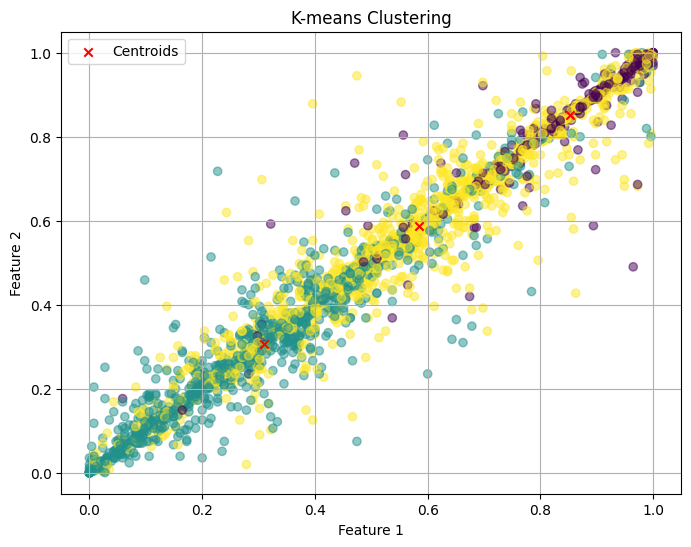

Manhattan Distance Clusters:


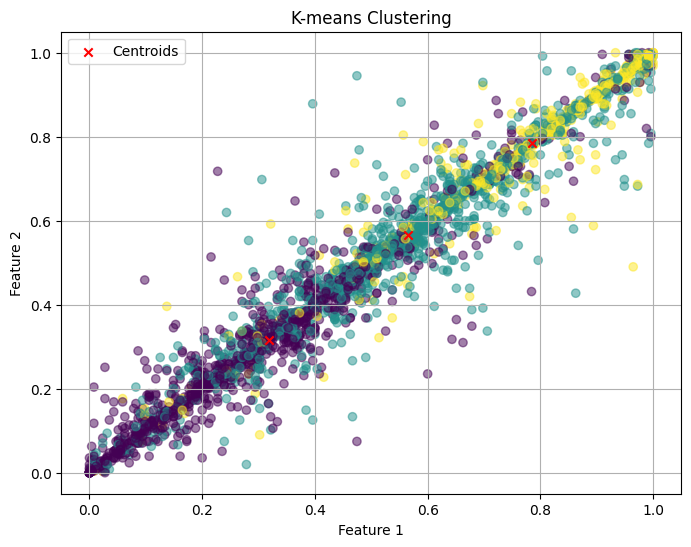

In [34]:
# Plot the clusters
print("Euclidean Distance Clusters:")
kmeans_euclidean.plot_clusters(x_test)

print("Manhattan Distance Clusters:")
kmeans_manhattan.plot_clusters(x_test)

# print("Cosine Similarity Clusters:")
# kmeans_cosine.plot_clusters(x_train)

In [40]:
!pip install gdown


In [42]:
import gdown

url = 'https://drive.google.com/uc?id=1-BfekMNZwWkQGfUMLm6Mx8lWv6DYX7Hr'
output = 'data_news'
output2 = 'news'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-BfekMNZwWkQGfUMLm6Mx8lWv6DYX7Hr
To: /content/data_news
100%|██████████| 1.08M/1.08M [00:00<00:00, 10.1MB/s]


'data_news'

In [51]:
url2 = 'https://drive.google.com/file/d/1-5R_FlIUa3GafCszQIfuf5jiLXf_t8cv/view'
data2 = gdown.download(url2, quiet=False)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1-5R_FlIUa3GafCszQIfuf5jiLXf_t8cv
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1-5R_FlIUa3GafCszQIfuf5jiLXf_t8cv/view
To: /content/view
82.2kB [00:00, 2.92MB/s]


In [43]:
data = gdown.download(url, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1-BfekMNZwWkQGfUMLm6Mx8lWv6DYX7Hr
To: /content/news_labels.npy
100%|██████████| 1.08M/1.08M [00:00<00:00, 9.87MB/s]


In [46]:
data = np.load(data)

In [53]:
data2


'view'

In [49]:
data.shape

(135264,)

In [3]:
import numpy as np
data2 = np.load('/content/drive/MyDrive/PRNN/Assign_3/News/news_vectors.npy')

In [4]:
data2.shape

(135264, 1000)

In [ ]:
# import json
# import numpy as np

# with open('/content/News_Category_Dataset_v3.json', 'r') as f:
#     lines = f.readlines()

#     category_list=[]
#     for line in lines:
#         json_data = json.loads(line)
#         category_list.append(json_data["category"])


# unique_categories, category_labels = np.unique(category_list, return_inverse=True)

# category_counts = np.bincount(category_labels)

# sorted_indices = np.argsort(category_counts)[::-1]
# sorted_categories = unique_categories[sorted_indices]
# sorted_counts = category_counts[sorted_indices]

# top_12_categories = sorted_categories[:12]

# for category in top_12_categories:
#     count = category_counts[np.where(unique_categories == category)]
#     print(f"{category}: {count}")
# # i=0
# top_news_data=[]
# with open('/content/News_Category_Dataset_v3.json', 'r') as f:
#     lines = f.readlines()
#     # i=i+1
#     print(lines)
#     for line in lines:
#         json_data = json.loads(line)
#         if json_data["category"] in top_12_categories:
#             record=[]
#             record.append(json_data["short_description"].strip('"'))
#             record.append(json_data["category"])
#             top_news_data.append(record)

In [ ]:
# train_size = int(0.7 * len(image_data))
# val_size = int(0.2 * len(image_data))
# test_size = len(image_data) - train_size - val_size

# # Shuffle the data
# indices = np.random.permutation(len(image_data))
# image_data_shuffled = image_data[indices]
# labels_shuffled = labels[indices]

# # Split the data into training, validation, and testing sets
# x_train = image_data_shuffled[:train_size]
# y_train = labels_shuffled[:train_size]

# x_val = image_data_shuffled[train_size:train_size+val_size]
# y_val = labels_shuffled[train_size:train_size+val_size]

# x_test = image_data_shuffled[train_size+val_size:]
# y_test = labels_shuffled[train_size+val_size:]

# # Print the shapes of the split sets
# print("Shape of x_train:", x_train.shape)
# print("Shape of y_train:", y_train.shape)
# print("Shape of x_val:", x_val.shape)
# print("Shape of y_val:", y_val.shape)
# print("Shape of x_test:", x_test.shape)
# print("Shape of y_test:", y_test.shape)